In [1]:
#Solving the toth equation

#When working with files, it is always a good idea to import os, which allows you to be computer-agnostic
import os
#To create basic animations (by repeatedly changing a figure), these internal subroutines of iPython must be imported
from IPython.display import clear_output, display

#Any type of plot that involves matrices will end up needing NumPy
import numpy as np
#Import the plotting libraries of Matplotlib (the most commonly used routines)
import matplotlib.pyplot as plt
#This method will import everything associated with SciPy, but to use it, you must work within submodules
import scipy as scipy
#This method will allow you more direct access to the linear algebra routines of SciPy
from scipy import linalg as LA
import time as tm


In [2]:
#Setup all constants for boundary conditions, discretization
nx = 15
nz = 9
ngrid = nx*nz
xmin, xmax = 0, 500
zmin, zmax = 0, 300
dy = 1
K = 10

x0_head = 50
head_slope = 0.002
head_oscamp = 0.01
head_osclen = 300


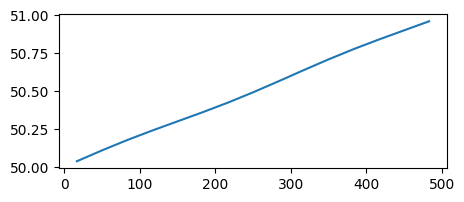

In [3]:
#Calculate grid spacing, grid centers, and grid boundaries

dx = (xmax-xmin)/nx
dz = (zmax-zmin)/nz
# Setup coordinates as iterated from left to right, top to bottom.
xc = np.linspace(xmin+(dx/2),xmax-(dx/2),nx)
zc = np.linspace(zmax-(dz/2),zmin+(dz/2),nz)
xgc,zgc = np.meshgrid(xc,zc)

xb = np.linspace(xmin,xmax,nx+1)
zb = np.linspace(zmax,zmin,nz+1)
xgb,zgb = np.meshgrid(xb,zb)

top_head = x0_head + head_slope*xc + head_oscamp*np.sin(2*np.pi/head_osclen*xc)

fig, axes = plt.subplots(1, 1, figsize=(5, 2))
axes.plot(xc,top_head)


Iterative (Python internal) method
Solving time =  0.000431060791015625
Direct method
Matrix inverse time =  0.0010230541229248047
RMSE =  3.542581100846947e-12


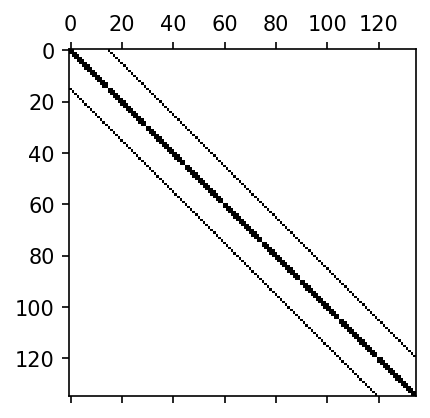

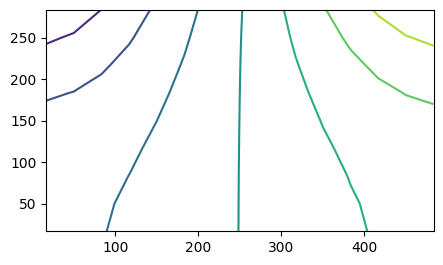

In [4]:
A = np.zeros((ngrid,ngrid))
b = np.zeros(ngrid)

row = 0
for i in range(nz):
    for j in range(nx):
        # print('i = ', i, 'j = ', j)
        cond_grid = np.zeros((nz,nx))
        srcs = 0
        if i == 0:
            # print('i=0')
            #When on top row - add source from top BC
            cdc = dx*dy*K/(dz/2)
            cond_grid[i,j] = cond_grid[i,j] - cdc
            srcs = srcs - top_head[j]*cdc
        else:
            # print('i<>0')
            cdc = dx*dy*K/dz
            cond_grid[i,j] = cond_grid[i,j] - cdc
            cond_grid[i-1,j] = cond_grid[i-1,j] + cdc
        if i == (nz-1):
            # print('i=(nz-1)')
            pass
            #When on bottom row - no sources from BC
        else:
            # print('i<>(nz-1)')
            cdc = dx*dy*K/dz
            cond_grid[i,j] = cond_grid[i,j] - cdc
            cond_grid[i+1,j] = cond_grid[i+1,j] + cdc
        if j == 0:
            # print('j=0')
            cond_grid = cond_grid
            #When at LHS - no sources from BC
        else:
            # print('j<>0')
            cdc = dz*dy*K/dx
            cond_grid[i,j] = cond_grid[i,j] - cdc
            cond_grid[i,j-1] = cond_grid[i,j-1] + cdc
        if j == (nx-1):
            # print('j=(nx-1)')
            pass
            #When at RHS - no sources from BC
        else:
            # print('j<>(nx-1)')
            cdc = dz*dy*K/dx
            cond_grid[i,j] = cond_grid[i,j] - cdc
            cond_grid[i,j+1] = cond_grid[i,j+1] + cdc
        # fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        # axes.imshow(cond_grid)
        cond_vec = np.reshape(cond_grid,(nx*nz))
        A[row,:] = cond_vec
        b[row] = srcs
        row = row + 1
        
#When creating a matrix by-hand, it is often good to be able to inspect it for errors.
fig = plt.figure(figsize=(3,3),dpi=150)
#You may use this to show all non-zero entries
plt.spy(A)

print('Iterative (Python internal) method')
tinit = tm.time()
hvec_solve = LA.solve(A,b)
t_solve = tm.time() - tinit
print('Solving time = ', t_solve)

print('Direct method')
tinit = tm.time()
Ainv = LA.inv(A)
hvec_inv = Ainv@b
t_inv = tm.time() - tinit
print('Matrix inverse time = ', t_inv)

#Check chosen solution
hvec = hvec_solve

#Check residual
Ahvec = A@hvec
resid = Ahvec - b
print('RMSE = ', np.sqrt(np.sum(resid**2)))

#Plot solution
hmat = np.reshape(hvec,(nz,nx))
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.contour(xgc,zgc,hmat)
# axes.pcolor(xgb,zgb,hmat)
axes.set_aspect('equal')

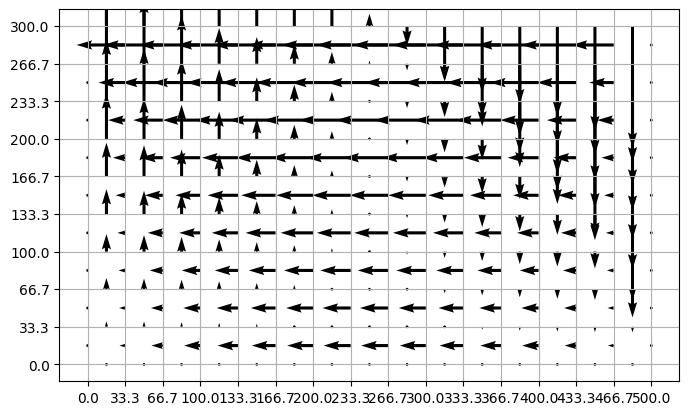

In [5]:
#Calculate x-direction and z-direction boundary fluxes based on the grid solution

qx_L = np.zeros((nz,1))
qx_R = np.zeros((nz,1))
qx_int = -K*np.diff(hmat,axis=1)/np.diff(xgc,axis=1)
qx_edges = np.concat((qx_L,qx_int,qx_R),axis=1)

#For qz_T - Need to re-add dimension here. Thanks Python.
qz_T = -K*np.expand_dims((top_head - hmat[1,:])/((zb[0] - zb[1])/2),0)
qz_int = -K*np.diff(hmat,axis=0)/np.diff(zgc,axis=0)
qz_B = np.zeros((1,nx))
qz_edges = np.concat((qz_T,qz_int,qz_B),axis=0)

qx_xgc, qx_zgc = np.meshgrid(xb,zc)
qz_xgc, qz_zgc = np.meshgrid(xc,zb)
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.quiver(qx_xgc, qx_zgc, qx_edges,0)
axes.quiver(qz_xgc, qz_zgc, 0,qz_edges)
axes.set_xticks(xb)
axes.set_yticks(zb)
axes.grid()
axes.set_aspect('equal')

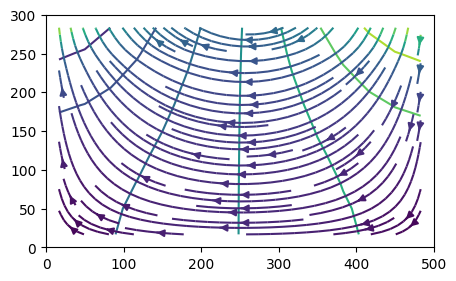

In [6]:
#Interpolate qx and qz to be on a consistent grid, at the grid cell centers
#Use this to produce approximate streamlines / particle traces

qx_inter = scipy.interpolate.RegularGridInterpolator((zc,xb),qx_edges)
qx = qx_inter((zgc,xgc))

qz_inter = scipy.interpolate.RegularGridInterpolator((zb,xc),qz_edges)
qz = qz_inter((zgc,xgc))

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
#axes.quiver(xgc,zgc,qx,qz)
axes.contour(xgc,zgc,hmat)
# axes.pcolor(xgb,zgb,hmat)

#streamplot requires strictly increasing values for first two inputs. Thanks Python.
zcf = np.flip(zc,0)
qxf = np.flip(qx,0)
qzf = np.flip(qz,0)
qmag = np.sqrt(qxf**2 + qzf**2)
axes.streamplot(xc,zcf,qxf,qzf,color=qmag)
axes.set_aspect('equal')
axes.set_xbound(xmin,xmax)
axes.set_ybound(zmin,zmax)